In [2]:
import os
import cv2
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import utils
from discriminators import define_Dis
from generators import define_Gen

In [3]:
crop_height = 128
crop_width = 128
dataset_dir = './datasets/sketch2pokemon'
checkpoint_dir = './checkpoints/sketch2pokemon'
checkpoint_name = 'latest'
results_dir = './results'
batch_size = 1
ngf = 64
norm = 'instance'
no_dropout = False
gpu_ids = []#[0]

test_length = 5

In [5]:
utils.create_link(dataset_dir)

{'trainA': './datasets/sketch2pokemon/ltrainA',
 'trainB': './datasets/sketch2pokemon/ltrainB',
 'testA': './datasets/sketch2pokemon/ltestA',
 'testB': './datasets/sketch2pokemon/ltestB'}

In [4]:
transform = transforms.Compose(
    [transforms.Resize((crop_height,crop_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset_dirs = utils.get_testdata_link(dataset_dir)

a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)


a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=batch_size, shuffle=False, num_workers=4) # set shuffle to false for testing
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Gab = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)
Gba = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)

utils.print_networks([Gab,Gba], ['Gab','Gba'])

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
-----------------------------------------------


In [5]:
try:
    ckpt = utils.load_checkpoint('%s/%s.ckpt' % (checkpoint_dir, checkpoint_name))
    Gab.load_state_dict(ckpt['Gab'])
    Gba.load_state_dict(ckpt['Gba'])
except:
    print(' [*] No checkpoint!')

./checkpoints/sketch2pokemon/latest.ckpt
 [*] No checkpoint!


In [ ]:
a_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainA'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainB'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

def gen(idx=0):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    for i in range(idx+1):
        a = itera.next()
        b = iterb.next()
    a_real_test = Variable(a[0], requires_grad=True)
    b_real_test = Variable(b[0], requires_grad=True)
    a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
            

    Gab.eval()
    Gba.eval()

    with torch.no_grad():
        a_fake_test = Gab(b_real_test)
        b_fake_test = Gba(a_real_test)
        a_recon_test = Gab(b_fake_test)
        b_recon_test = Gba(a_fake_test)

        pic = (torch.cat([a_real_test, b_fake_test], dim=0).data + 1) / 2.0

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        torchvision.utils.save_image(pic, results_dir+'/sample_%d.jpg' % idx, nrow=3)

def print_test(len):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    for i in range(len):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            a_fake_test = Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            a_recon_test = Gab(b_fake_test)
            b_recon_test = Gba(a_fake_test)

            res.extend([a_real_test, b_fake_test, b_real_test])

    pic = (torch.cat(res, dim=0).data + 1) / 2.0

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    torchvision.utils.save_image(pic, results_dir+'/result_%d.jpg' % ckpt['epoch'], nrow=6)

# idx = 16
# gen(idx)
# from IPython.display import Image
# Image(filename=results_dir+'/sample_%d.jpg' % idx) 

print_test(8)

from IPython.display import Image
Image(filename=results_dir+'/result_%d.jpg' % ckpt['epoch']) 


Bad key text.latex.unicode in file /home/ykaixin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.dvipnghack in file /home/ykaixin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 127 ("text.dvipnghack : None      # some versions of dvipng don't handle alpha")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/ykaixin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 430 ('savefig.frameon : True')
You probably need to 

TypeError: 'NoneType' object is not iterable

## Metrics

Test and generate colourings --> then use metric

In [7]:
def readImage(path):
    return cv2.imread(path)

def computeMetrics(imga, imgb):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    print('HistCompare_correlation: ', corr)
    print('HistCompare_chi_square: ', chisq)
    print('HistCompare_intersction: ', intersectn)
    print('HistCompare_bhat: ', bhat)

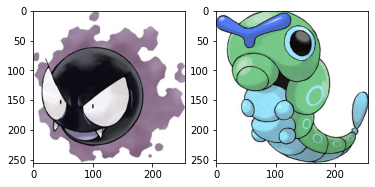

In [33]:
imga = readImage('./datasets/sketch2pokemon/testB/90_B.jpg')
imgb = readImage('./datasets/sketch2pokemon/testB/9_B.jpg')

import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(imga)
plt.subplot(122)
plt.imshow(imgb)
plt.show()

In [18]:
computeMetrics(imga, imgb) #exact same ghastly

HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  3.0995080839202274
HistCompare_bhat:  0.0


In [26]:
computeMetrics(imga, imgb) #onix onix

HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  1.9458432234896463
HistCompare_bhat:  1.0536712127723509e-08


from here can see that intersection and bhat is not ideal cus dif values despite identity

In [20]:
computeMetrics(imga, imgb) #ghastly haunter

HistCompare_correlation:  0.9799285476041358
HistCompare_chi_square:  2.0154848364415345
HistCompare_intersction:  1.0820836799575773
HistCompare_bhat:  0.6975679657159936


In [22]:
computeMetrics(imga, imgb) #ghastly gengar

HistCompare_correlation:  0.9736436601484993
HistCompare_chi_square:  2.1930900109101694
HistCompare_intersction:  1.0864145131054102
HistCompare_bhat:  0.758480429005484


In [24]:
computeMetrics(imga, imgb) #ghastly onix

HistCompare_correlation:  0.9783083282890952
HistCompare_chi_square:  2.4059933619973037
HistCompare_intersction:  1.0692740663944278
HistCompare_bhat:  0.7401755124697869


In [28]:
computeMetrics(imga, imgb) #ghastly mutant_drowzee

HistCompare_correlation:  0.969588566348377
HistCompare_chi_square:  10.879578888325456
HistCompare_intersction:  1.1577566423584358
HistCompare_bhat:  0.7142052625568617


chisq seems gd ah

In [34]:
computeMetrics(imga, imgb) #ghastly caterpie

HistCompare_correlation:  0.9767693072593291
HistCompare_chi_square:  2.3627164266046816
HistCompare_intersction:  1.129925356239255
HistCompare_bhat:  0.7505798071510059


In [8]:
def save_sample_image(test_length):
    temp_dir = './temp'
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    average_hist_score_correlation = 0.0
    average_hist_score_chi_square = 0.0
    average_hist_score_intersction = 0.0
    average_hist_score_bhat = 0.0
    for i in range(test_length):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            # a_fake_test = self.Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            # a_recon_test = self.Gab(b_fake_test)
            # b_recon_test = self.Gba(a_fake_test)

            res.extend([a_real_test, b_fake_test, b_real_test])

            ##### Generate histogram similarity score
            # Documentation: https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
            torchvision.utils.save_image(b_fake_test.cpu(), temp_dir + '/model_output' + i + '.jpg')
            torchvision.utils.save_image(b_real_test.cpu(), temp_dir + '/groundtruth' + i + '.jpg')
            src_base = cv2.imread(temp_dir + '/groundtruth.jpg')
            src_test1 = cv2.imread(temp_dir + '/model_output.jpg')
            hsv_base = cv2.cvtColor(src_base, cv2.COLOR_BGR2HSV)
            hsv_test1 = cv2.cvtColor(src_test1, cv2.COLOR_BGR2HSV)
            h_bins = 50
            s_bins = 60
            v_bins = 60
            histSize = [h_bins, s_bins, v_bins]
            # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
            h_ranges = [0, 180]
            s_ranges = [0, 256]
            v_ranges = [0, 256]
            ranges = h_ranges + s_ranges + v_ranges# concat lists
            # Use 0,1,2nd channels
            channels = [0, 1, 2]
            hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
            corr = cv2.compareHist(hist_base, hist_test1, 0)
            average_hist_score_correlation += corr
            chisq = cv2.compareHist(hist_base, hist_test1, 1)
            average_hist_score_chi_square += chisq
            intersectn = cv2.compareHist(hist_base, hist_test1, 2)
            average_hist_score_intersction += intersectn
            bhat = cv2.compareHist(hist_base, hist_test1, 3)
            average_hist_score_bhat += bhat
            # os.remove(temp_dir + '/model_output.jpg')
            # os.remove(temp_dir + '/groundtruth.jpg')
            print('HistCompare_correlation: ', corr)
            print('HistCompare_chi_square: ', chisq)
            print('HistCompare_intersction: ', intersectn)
            print('HistCompare_bhat: ', bhat)

    print('aveHistCompare_correlation: ', average_hist_score_correlation / test_length)
    print('aveHistCompare_chi_square: ', average_hist_score_chi_square / test_length)
    print('aveHistCompare_intersction: ', average_hist_score_intersction / test_length)
    print('aveHistCompare_bhat: ', average_hist_score_bhat / test_length)


In [9]:
save_sample_image(5)

TypeError: 'NoneType' object is not iterable